<a href="https://colab.research.google.com/github/michalis0/BigScaleAnalytics/blob/master/week6/Recommender_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining and Machine Learning - Week 6
# Recommender Systems

A [recommender system](https://en.wikipedia.org/wiki/Recommender_system) is a subclass of information filtering system that seeks to predict the "rating" or "preference" a user would give to an item. They are primarily used in commercial applications.


### Table of Contents
#### 1. User-User Collaborative Filtering From Scratch
* 1.1 Download the data
* 1.2 Import modules and load data
* 1.3 Data visualization
* 1.4 Truncate the data
* 1.5 Preprocess the data
* 1.6 Create the Ratings Matrix
* 1.7 User Average Ratings
* 1.8 Compute User-User Similarity 
* 1.9 User to all Users Similarities
* 1.10 Create User Neighborhood 
* 1.11 Predict a Rating 
* 1.12 Recommendation Exercise

#### 2. Using the Surprise library
* 2.1 Some helper functions
* 2.2 Visualizing the recommendations
* 2.3 Cross-validation using surprise
* 2.4 Precision - Recall @k
* 2.5 Tuning hyper-parameters with surprise

## 1. User-User Collaborative Filtering From Scratch
We implement User-User Collaborative Filtering from scratch i.e. by only using numpy and scipy libraries. We use the MovieLens 20M dataset.

### 1.1 Download the data
We download the MovieLens 20M dataset from <http://files.grouplens.org/datasets/movielens/ml-20m.zip>, extract the contents of the zip file as a folder named `data` located in the same folder as this notebook. You should have a file `ml-20m/ratings.csv`, which is what we'll be working with.

In [ ]:
# Download data
!pip install wget
!mkdir data
import wget
filename = wget.download("http://files.grouplens.org/datasets/movielens/ml-20m.zip", out="data/ml-20m.zip")

In [ ]:
# Unzip the zip file to get the data-sets
!unzip data/ml-20m.zip

### 1.2 Import modules and load data

In [3]:
# Import requiered packages
import csv
import pandas as pd
import numpy as np
from scipy import sparse as sp
from scipy.sparse.linalg import norm
import sklearn.preprocessing as pp
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Set some formatting options
np.set_printoptions(threshold=500, precision=4)
pd.options.display.max_seq_items = 20
pd.options.display.max_rows = 20

Load data from csv files.

In [4]:
ratings_raw = pd.read_csv('ml-20m/ratings.csv')
movies = pd.read_csv('ml-20m/movies.csv')
links = pd.read_csv('ml-20m/links.csv')

Let's see what the data looks like.

In [5]:
display(ratings_raw.head())
display(movies.head())
display(links.head())
print("Distinct users:", len(ratings_raw.userId.unique()))
print("Distinct items:", len(ratings_raw.movieId.unique()))

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


Distinct users: 138493
Distinct items: 26744


In [6]:
# Example to keep in mind for later --> id is 480
movies[movies.title == 'Jurassic Park (1993)']

,movieId,title,genres
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller


### 1.3 Data visualization
Lets visualize some of the movie data. We will use [tmdbsimple](https://pypi.org/project/tmdbsimple/) which is a wrapper, written in Python, for The Movie Database (TMDb) API v3.

In [7]:
# Install package
!pip install tmdbsimple

We directly import a module from GitHub. It runs the `__init__.py` file, which contains a class we need called `TMDB`.

In [8]:
# Import module from GitHub
from httpimport import github_repo
with github_repo(username='michalis0', repo='BigScaleAnalytics', module='week6'):
  import week6

week6

<module 'week6' (<httpimport.HttpImporter object at 0x7f9da7c19950>)>

In [9]:
from IPython.display import Image
from IPython.display import display, HTML

# Which movies did user watch?
def make_html(image_url):
     return '<img src="{}" style="display:inline;margin:1px" width="100"/>'\
            .format(image_url)
        
def show_movies_for_user(userId, verbose=False, show_all=False):
    """Retrieve posters of top rated movies for userId.
    
    Note: this accepts the original user id
    """
    html = ''
    max_movies = 10
    i=0
    
    user_movies = ratings_raw[ratings_raw.userId == userId]["movieId"]
    print("User ", userId , " watched ", len(user_movies), ' movies') 
    
    user_movies = ratings_raw[ratings_raw.userId == userId].sort_values("rating", ascending=False) 
    for index, row in user_movies.iterrows():
        movieId = row["movieId"]
        movie_item = links[links.movieId == movieId]
        tmdbId = movie_item["tmdbId"].item()
        if verbose:
            print(movieId, tmdbId)
        if np.isnan(tmdbId):
            url = None
        else:
            url = week6.TMDB().get_poster_path_by_id(int(tmdbId)) # use imported module
        html = html + make_html(url)
        i +=1
        
        if ~show_all and (i == max_movies):
                break
        
    display(HTML(html))

In [10]:
# Let's see which movies user 6 watched
show_movies_for_user(6, verbose=False) 

User  6  watched  24  movies


In [22]:
# Show this in ratings_raw
ratings_raw[ratings_raw.userId == 6].sort_values("rating", ascending=False).head(10).set_index('movieId').\
                                    join(movies.set_index('movieId'), on='movieId')

,userId,rating,timestamp,title,genres
movieId,,,,,
1,6,5.0,858275452,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
52,6,5.0,858275658,Mighty Aphrodite (1995),Comedy|Drama|Romance
141,6,5.0,858275452,"Birdcage, The (1996)",Comedy
62,6,5.0,858275452,Mr. Holland's Opus (1995),Drama
648,6,5.0,858275452,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller
17,6,5.0,858275452,Sense and Sensibility (1995),Drama|Romance
7,6,5.0,858275558,Sabrina (1995),Comedy|Romance
628,6,4.0,858275783,Primal Fear (1996),Crime|Drama|Mystery|Thriller
788,6,4.0,858275658,"Nutty Professor, The (1996)",Comedy|Fantasy|Romance|Sci-Fi


In [23]:
# Some helper functions
def get_name_for_movie_id(movie_id):
    """Returns the name of a movie_id (based on ratings_raw i.e. original id)"""
    
    try: 
        movie_name = movies[movies.movieId == movie_id]["title"].item()
    except KeyError:
        movie_name = None
    return movie_name
    
    
def show_genres_histogram_for_user(user_id):
    """Create histogram of movies genres user_id has watched.
    
    Note: this uses the original user_id NOT the userIDX
    """
    
    user_movies = ratings_raw[ratings_raw.userId == user_id]["movieId"]
    print("User ", user_id , " watched ", len(user_movies), ' movies') 
    user_movies_with_genre = movies[movies.movieId.isin(user_movies)]
    display(user_movies_with_genre)
    
    genres_list = []
    for index, row in user_movies_with_genre.iterrows():
        genres_list += row["genres"].split('|')
    
    df_genres = pd.DataFrame(genres_list, columns=['genres'])
    
    df_genres.groupby('genres').size().sort_values().plot(kind='barh')

In [27]:
get_name_for_movie_id(1)

'Toy Story (1995)'

User  6  watched  24  movies


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
6,7,Sabrina (1995),Comedy|Romance
16,17,Sense and Sensibility (1995),Drama|Romance
51,52,Mighty Aphrodite (1995),Comedy|Drama|Romance
...,...,...,...
749,762,Striptease (1996),Comedy|Crime
767,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller
775,788,"Nutty Professor, The (1996)",Comedy|Fantasy|Romance|Sci-Fi
789,802,Phenomenon (1996),Drama|Romance


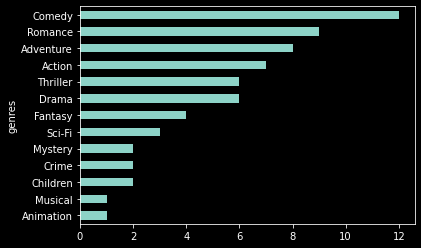

In [24]:
# Now we can see what user 6 watched
show_genres_histogram_for_user(6)

### 1.4 Truncate the data

To speed things up, we will work with a *truncated* version of the data, containing up to 10000 users and 1000 movies. 

**Important:** To see results with the full dataset, set `DEBUG = False`, and **rerun all cells starting from the top**. But be careful this may take a long time.

In [28]:
DEBUG = True
if DEBUG: 
    ratings_raw = ratings_raw[ (ratings_raw['userId'] < 10000) & (ratings_raw['movieId'] < 1000) ]

In [32]:
ratings_raw.userId.nunique()

9924

### 1.5 Preprocess the data
We make sure that movies and users have consecutive indexes starting from 0. Also drop the timestamp column.

The resulting "cleaned" data are stored in `ratings`.

In [33]:
# Unique movies and users
movieIds = ratings_raw.movieId.unique()
movieIds.sort()
userIds = ratings_raw.userId.unique()
userIds.sort()

# Size
m = userIds.size
n = movieIds.size
numRatings = len(ratings_raw)

print ("There are", m, "users,", n, "items and", numRatings, "ratings.")

## Movies and users should have consecutive indexes starting from 0
# dictionaries to convert movie id to consecutive index and vice versa
movieId_to_movieIDX = dict(zip(movieIds, range(0, movieIds.size)))
movieIDX_to_movieId = dict(zip(range(0, movieIds.size), movieIds))

# Dictionaries to convert user id to consecutive index and vice versa
userId_to_userIDX = dict(zip(userIds, range(0, userIds.size )))
userIDX_to_userId = dict(zip(range(0, userIds.size), userIds))

# Drop timestamps
ratings = pd.concat([ratings_raw['userId'].map(userId_to_userIDX),
                     ratings_raw['movieId'].map(movieId_to_movieIDX),
                     ratings_raw['rating']], axis=1)
ratings.columns = ['user', 'item', 'rating']

display(ratings.head(20))

There are 9924 users, 968 items and 394638 ratings.


,user,item,rating
0,0,1,3.5
1,0,28,3.5
2,0,31,3.5
3,0,46,3.5
4,0,49,3.5
5,0,110,3.5
6,0,148,4.0
7,0,219,4.0
8,0,249,4.0
9,0,256,4.0


We therefore have an index (IDX) and an ID for each movie (item) and each user.

In [34]:
# Example - index to id
for idx in range(40):
  print(idx, userIDX_to_userId[idx])

0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 38
37 39
38 40
39 41


In [35]:
# Example - id to index
for id in range(0, 40):
  try:
    print(id, userId_to_userIDX[id])
  except:
    print('There is nobody with id = ' + str(id))

There is nobody with id = 0
1 0
2 1
3 2
4 3
5 4
6 5
7 6
8 7
9 8
10 9
11 10
12 11
13 12
14 13
15 14
16 15
17 16
18 17
19 18
20 19
21 20
22 21
23 22
24 23
25 24
26 25
27 26
28 27
29 28
30 29
31 30
32 31
33 32
34 33
35 34
36 35
There is nobody with id = 37
38 36
39 37


In [36]:
# Describe
ratings.groupby(by='user').describe()

item                                                             rating  \
     count        mean         std   min     25%    50%     75%    max  count   
user                                                                            
0     21.0  326.047619  269.698624   1.0  110.00  289.0  534.00  895.0   21.0   
1     14.0  405.785714  313.926052   2.0  140.50  362.0  568.50  895.0   14.0   
2     34.0  472.970588  294.260911   0.0  228.25  461.5  742.75  939.0   34.0   
3     28.0  388.750000  189.313893   5.0  349.50  418.5  515.75  712.0   28.0   
4     52.0  415.673077  216.628599   1.0  272.50  448.5  581.75  805.0   52.0   
...    ...         ...         ...   ...     ...    ...     ...    ...    ...   
9919  29.0  337.896552  235.606868   1.0  169.00  292.0  548.00  758.0   29.0   
9920   6.0  490.333333  306.110873  16.0  352.00  516.5  653.25  897.0    6.0   
9921  93.0  393.569892  271.669692   1.0  155.00  372.0  588.00  964.0   93.0   
9922  19.0  410.684211  300.873922   0.0  143.00  403.0  654.00  883.0   19.0   
9923  15.0  429.133333  193.271041  31.0  326.50  427.0  580.50  758.0   15.0   

                                                      
          mean       std  min   25%  50%    75%  max  
user                                                  
0     3.666667  0.288675  3.0  3.50  3.5  4.000  4.0  
1     4.285714  0.994490  2.0  4.00  5.0  5.000  5.0  
2     4.058824  1.013281  2.0  3.00  4.0  5.000  5.0  
3     3.571429  0.790151  1.0  3.00  4.0  4.000  5.0  
4     4.153846  0.977885  2.0  3.00  4.5  5.000  5.0  
...        ...       ...  ...   ...  ...    ...  ...  
9919  3.896552  1.144703  1.0  3.00  4.0  5.000  5.0  
9920  4.166667  0.258199  4.0  4.00  4.0  4.375  4.5  
9921  3.344086  0.787050  1.0  3.00  3.0  4.000  5.0  
9922  3.236842  1.206100  1.0  2.75  3.5  4.000  5.0  
9923  4.233333  0.677882  2.5  4.00  4.0  4.750  5.0  

[9924 rows x 16 columns]

### 1.6 Create the Ratings Matrix

We convert the `ratings DataFrame` into a **Ratings Matrix**. Because it is very sparse, we use the `scipy.sparse` module to efficiently store and access it.

Specifically, we create **two** versions of the same ratings matrix:
- `R` is our basic matrix and is optimized for dot products, which will be useful when computing user-user similarities; `R` is stored in the Compressed Sparse Row format (`csr_matrix`).
- `R_dok` is a different view of the ratings matrix, which allows to quickly test whether a user-item rating exists; `R_dok` is stored in the Dictionary Of Keys format (`dok_matrix`) so you can access the data like a dictionary (which is fast).

In [37]:
# Create matrices
R = sp.csr_matrix((ratings.rating, (ratings.user, ratings.item))) # input is (data value, (index 0, index 1))
R_dok = R.todok()

# A simple test: user 0 item 534 should have a rating of 4
print("R[0, 534] value is ", R[0, 534])
print("R_dok[(0, 534)] value is ", R_dok[(0, 534)])

R[0, 534] value is  4.0
R_dok[(0, 534)] value is  4.0


In [38]:
# Check - same as before :)
m = R.shape[0]
n = R.shape[1]
numRatings = R.count_nonzero()

print("There are m =", m, "users, n =", n, "items and", numRatings, "ratings.")

There are m = 9924 users, n = 968 items and 394638 ratings.


The fun starts here! :)

### 1.7 User Average Ratings

The following code computes the average rating of each user. This will be useful for mean-centering, i.e., when computing similarities, as well as for making predictions.

In [41]:
user_sums = R.sum(axis=1).A1 # matrix converted to 1-D array via .A1
user_cnts = np.diff(R.indptr) # equivalent to, but faster than: user_cnts = (R != 0).sum(axis=1).A1
user_avgs = user_sums / user_cnts
print("user_avgs", user_avgs)

user_avgs [3.6667 4.2857 4.0588 ... 3.3441 3.2368 4.2333]


[This thread](https://stackoverflow.com/questions/52299420/scipy-csr-matrix-understand-indptr) in stack overflow, explains the method `indptr` for a sparse matrix in scipy clearly. Recommended to read for those who are inerested or got confused with the above code.

### 1.8 Compute User-User Similarity 

The following function computes the **mean-centered cosine similarity** between two users.

**IMPORTANT**: from now on, we work with `R` and `R_dok`. This means that we work with the IDX, not the ids anymore. 

*Tricks* that are useful:

To subtract a scalar value `y` from all nonzero entries of a sparse vector `x`, do:
```
x.data = x.data - y
```

The dot product of a sparse vector `x` to sparse vector `y` is:
```
x.dot(y.T)
```

The norm of a sparse vector `x` is:
```
norm(x)
```


If a sparse vector `x` has only a single item, you can access it by:
```
x.A.item()
```

Note that `x.A` returns the dense representation of sparse vector `x`.

In [42]:
# Some examples
u = R[1,:].copy() 
v = R[2,:].copy()
print(type(u.data))
print(u.dot(v.T))
print(u.dot(v.T).A)
print(u.dot(v.T).A.item()) # this is the dot product of user 1 and user 2

<class 'numpy.ndarray'>
  (0, 0)	120.0
[[120.]]
120.0


In [43]:
def compute_pairwise_user_similarity(u_id, v_id):
    """Computes the cosine similarity between two user ids.
    dot(A,B)/norm(A)*norm(B)
    Note: we use it with the IDX!
    """
    u = R[u_id,:].copy()
    v = R[v_id,:].copy()
    
    # Compute the numerator i.e. dot product of the mean centered arrays
    u.data = u.data - user_avgs[u_id]
    v.data = v.data - user_avgs[v_id]
    
    numerator =  (u.dot(v.T)).A.item()
    
    # Compute demoninator i.e. product of the norms
    denominator = norm(u) * norm(v)
    
    # Compute similarity
    if denominator == 0:
        similarity = 0.;
    else:
        similarity = numerator/denominator
    
    return similarity

**DEBUG:** For the truncated dataset, the following should output ~ `0.03585`.

In [44]:
if DEBUG:
    sim = compute_pairwise_user_similarity(2, 6) # for example checking similarity of user 2 and user 6
    print(round(sim, 5))

0.03585


Here the interpretation is that the two users are not very similar.

Similarity will be between -1 and +1, from very dissimilar to very similar.

### 1.9 User to all Users Similarities

The following functions compute the mean-centered cosine similarities of a given user to all other users.

We first use the `compute_pairwise_user_similarity` function defined above.

Then we try to avoid the for loop and **NOT** invoke `compute_pairwise_user_similarity`. The idea is to obtain a copy, say `R_copy`, of matrix `R` that has its rows mean-centered and normalized. This way the given user can be represented by a mean-centered and normalized vector `u`. Then, to obtain the similarity of the user to all others, one needs to take the dot product `R_copy.dot(u.T)`.

In [45]:
def compute_user_similarities(u_id):
    uU = np.empty((m,)) # we have m users
  	
    # With for loop
    for v_id in range(m):
        sim = compute_pairwise_user_similarity(u_id, v_id)
        uU[v_id] = sim
    
    return uU

def compute_user_similarities_fast(u_id):
    uU = np.empty((m,))
    
    global user_avgs, user_cnts # we already derived these two vectors
    
    R_copy = R.copy() ## create a copy to work with
    # Repeat each user_avg, user_cnt times
    user_avgs_repeated = np.repeat(user_avgs, user_cnts)

    R_copy.data -= user_avgs_repeated # R_copy is now mean centered
    
    # Normalize rows to unit norm
    R_copy = pp.normalize(R_copy, axis=1) # normalize each row: elements divided by the row norm
    u = R_copy[u_id, :]

    uU = R_copy.dot(u.T).A.flatten() # dot product; convert to dense matrix, then flatten
    return uU

**DEBUG:** For the truncated dataset, the following should again output ~ `0.03585`.

In [47]:
import time
if DEBUG:
    start = time.time()
    uU = compute_user_similarities(2)
    print("Time for the first function with for loop=", (time.time()-start))
    
    start = time.time()
    uU = compute_user_similarities_fast(2)
    print("Time for second function using R_copy=", (time.time()-start))
    
    print(round(uU[6], 5))  # print the similarity of user 2 with user 6

Time for the first function with for loop= 14.84195065498352
Time for second function using R_copy= 0.019097566604614258
0.03585


In [48]:
print(uU.shape); print(uU) ## uU stores the similarity of user 2 to all the other users.

(9924,)
[ 0.1318  0.1268  1.     ...  0.0994  0.0856 -0.0639]


In [49]:
np.argsort(uU)[-2] # most similar user to user with user index 2. 
# Note: we take the penultimate one since the last one is user 2 with a similarity = 1

1871

In [50]:
# Similarity between user 2 and user 1871
uU[1871]

0.40612029851395737

Now let's compare the top 10 rated movies by user index 2 and user index 1871 which is the most similar user to user index 2.

In [51]:
show_movies_for_user(userIDX_to_userId[2]) # note that we use userIDX_to_userId

User  3  watched  34  movies


In [52]:
show_movies_for_user(userIDX_to_userId[1871])

User  1883  watched  14  movies


### 1.10 Create User Neighborhood 

The following function creates the user neighborhood of a given user. It takes as input, the target user `u_id` and the target item `i_id`, and uses additional parameters, the size `k` of the neighborhood, and a flag `with_abs_sim`.

If `with_abs_sim` is `True`, the neighborhood should contain up to `k` users with the highest absolute similarity to the target user `u_id`.

If `with_abs_sim` is `False`, the neighborhood should contain up to `k` users with the highest similarity to the target user `u_id`.

The output of the function is `nh`, a `Dictionary` containing key-value entries of the form `v_id : sim(u_id, v_id)`, where `v_id` is another user and `sim(u_id, v_id)` is the similarity between `u_id` and `v_id`.

**Note:** The neighborhood of the target user should not contain itself, i.e., `u_id`, and only include users that have rated the target item `i_id`.


*Tricks* that might be useful:

`np.absolute(x)` returns an array containing the absolute values of each element in array `x`.

`np.argsort(x)` returns an array with the indices that sort array `x` in *increasing* order.

`x[::-1]` returns the reversed array of `x`. So, `np.argsort(x)[::-1]` contains the indices that sort x in *decreasing* order.

To check if user `u_id` has rated item `i_id`, the `R_dok` view of the ratings matrix is helpful:
```
(u_id, i_id) in R_dok
```

In [53]:
def create_user_neighborhood(u_id, i_id, k=5, with_abs_sim=False):
    """ Neighborhood for user "u_id" that have also watched item "i_id"
    """
    nh = {} ## the neighborhood dict with (user id: similarity) entries
    ## nh should not contain u_id and only include users that have rated i_id; there should be at most k neighbors
    
    uU = compute_user_similarities(u_id)
    uU_copy = uU.copy() ## so that we can modify it, but also keep the original
    
    # Absolute similarity
    if with_abs_sim:
        uU_copy = np.absolute(uU_copy)  # we only care about the absolute value of the similarity
    
    # Derive the user_ids sorted by decreasing similarity (or absolute similarity) to u_id
    user_ids =  np.argsort(uU_copy)[::-1]
    
    # Create neighborhood
    count = 0
    for v_id in user_ids:
        if v_id == u_id: ## ignore self
            continue # go to the next iterate of the loop 
        # ignore users that have not rated i_id
        if (v_id, i_id) not in R_dok: 
            continue
        nh[v_id] = uU[v_id]
        count += 1
        if count == k:
            break
    
    return nh

In [54]:
# Compute neighborhood for user (idx) 2 and movie (id) 480 (Jurassic Park)
if DEBUG:
    print(get_name_for_movie_id(movie_id=480))
    nh = create_user_neighborhood(u_id=2, i_id=movieId_to_movieIDX[480]) # note that we use movieId_to_movieIDX
    print(nh)

Jurassic Park (1993)
{1871: 0.4061202985139574, 3820: 0.3846678392678671, 5397: 0.3690218927524379, 9901: 0.3652397219173058, 2763: 0.3639771081615157}


In [55]:
compute_pairwise_user_similarity(2, 1871)

0.4061202985139574

Now we have seen what are the most similar users to user 2 that have also watched `Jurassic Park`.

User  3  watched  34  movies


User  3  watched  34  movies


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
23,24,Powder (1995),Drama|Sci-Fi
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
49,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
158,160,Congo (1995),Action|Adventure|Mystery|Sci-Fi
...,...,...,...
888,905,It Happened One Night (1934),Comedy|Romance
902,919,"Wizard of Oz, The (1939)",Adventure|Children|Fantasy|Musical
907,924,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi
936,953,It's a Wonderful Life (1946),Drama|Fantasy|Romance


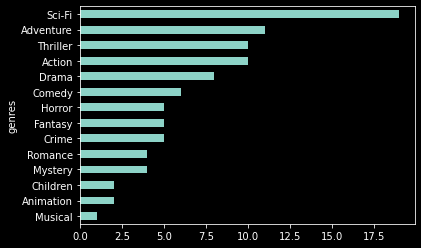

In [56]:
# User 2
show_movies_for_user(userIDX_to_userId[2])
show_genres_histogram_for_user(userIDX_to_userId[2])

User  3847  watched  18  movies


User  3847  watched  18  movies


,movieId,title,genres
1,2,Jumanji (1995),Adventure|Children|Fantasy
158,160,Congo (1995),Action|Adventure|Mystery|Sci-Fi
170,172,Johnny Mnemonic (1995),Action|Sci-Fi|Thriller
183,185,"Net, The (1995)",Action|Crime|Thriller
194,196,Species (1995),Horror|Sci-Fi
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
313,316,Stargate (1994),Action|Adventure|Sci-Fi
431,435,Coneheads (1993),Comedy|Sci-Fi
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
537,541,Blade Runner (1982),Action|Sci-Fi|Thriller


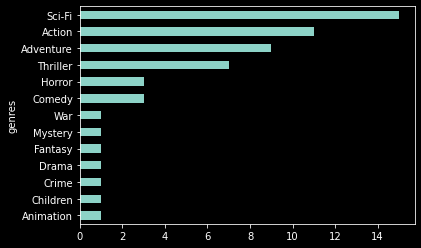

In [57]:
# Now we can see what movies the userIDX 3820 (the second most similar to user_idx=2) has watched.
show_movies_for_user(userIDX_to_userId[3820])
show_genres_histogram_for_user(userIDX_to_userId[3820])

### 1.11 Predict a Rating 

Finally! We can now try to predict a rating of a given user who has not rated an item so far. Follow the instructions bellow to see how we can do this!

The following function predicts the rating user `u_id` would give to item `i_id`. It uses the flag `with_deviations` to make the prediction.

If `with_deviations` is `True`, the prediction is made over *rating deviations*:
$$ s(u,i) = \overline{r_u} + \frac{\sum_{v \in N(u;i)}w_{uv} (r_{vi}-\overline{r_v})}{\sum_{v \in N(u;i)} |w_{uv}|} .$$

If `with_deviations` is `False`, the prediction is made directly over ratings:
$$ s(u,i) = \frac{\sum_{v \in N(u;i)}w_{uv} r_{vi}}{\sum_{v \in N(u;i)} |w_{uv}|} .$$

The output of the function is the predicted rating `prediction`.

In [58]:
def predict_rating(u_id, i_id, k, with_deviations=True, with_abs_sim=False):
    '''
    predict the rating of user u_id for item i_id 
    '''
    
    print("Movie name:", get_name_for_movie_id(movie_id=movieIDX_to_movieId[i_id]))
    
    if (u_id, i_id) in R_dok:
        print("user idx", u_id, "has rated item idx", i_id, "with", R[u_id, i_id])
    else:
        print("user idx", u_id, "has not rated item idx", i_id)
    print("k:", k, "with_deviations:", with_deviations, "with_abs_sim:", with_abs_sim)
    
    # Neighborhood
    nh = create_user_neighborhood(u_id, i_id, k=k, with_abs_sim=with_abs_sim)
    
    
    neighborhood_weighted_avg = 0. # neighborhood_weighted_avg is the fraction in the above formulas

    # Average - same as before
    user_sums = R.sum(axis=1).A1 ## matrix converted to 1-D array via .A1
    user_cnts = np.diff(R.indptr) ## equivalent to, but faster than: user_cnts = (R != 0).sum(axis=1).A1
    user_avgs = user_sums / user_cnts

    # Compute fraction
    sum_scores = 0. # numerator
    sum_weights = 0. # denominator
    for neighbor_id, similarity in nh.items():
        # Find the neighbor rating from R matrix.
        neighbor_rating = R[neighbor_id, i_id]
        if with_deviations:
            # In this case similarity should be multiplied by (neighbor_rating - neighbor_avg)
            sum_scores += similarity * (neighbor_rating - user_avgs[neighbor_id])
        else:
            # In this case we do not have the average
            sum_scores += similarity * neighbor_rating
        sum_weights += abs(similarity)
        
    neighborhood_weighted_avg = sum_scores/sum_weights
    
    if with_deviations:
        prediction = user_avgs[u_id] + neighborhood_weighted_avg
        print("prediction", prediction, "(user_avg", user_avgs[u_id], ", offset", neighborhood_weighted_avg, ")")
    else:
        prediction = neighborhood_weighted_avg
        print("prediction", prediction, "(user_avg", user_avgs[u_id], ")")
        
    return prediction

**DEBUG:** For the truncated dataset, the following should output sth like:
```
Movie name: Sudden Death (1995)
user 6 has not rated item 8
k: 50 with_deviations: True with_abs_sim: True
prediction 2.7554307504988773 (user_avg 3.2830188679245285 offset -0.527588117425651 )
```

In [59]:
if DEBUG:
    k = 50  # number of neighbours
    with_deviations = True
    with_abs_sim = True
    predict_rating(6, 8, k=k, with_deviations=with_deviations, with_abs_sim=with_abs_sim) 
    # predict rating for user with index 6 for movie with index 8

Movie name: Sudden Death (1995)
user idx 6 has not rated item idx 8
k: 50 with_deviations: True with_abs_sim: True
prediction 2.7554307504988773 (user_avg 3.2830188679245285 , offset -0.527588117425651 )


In [60]:
# Compute prediction of user 2 for Jurassic Park
if DEBUG:
    k = 50
    with_deviations = True
    with_abs_sim = True
    predict_rating(2, movieId_to_movieIDX[480], k=k, with_deviations=with_deviations, with_abs_sim=with_abs_sim)

Movie name: Jurassic Park (1993)
user idx 2 has rated item idx 473 with 5.0
k: 50 with_deviations: True with_abs_sim: True
prediction 4.47965667390943 (user_avg 4.0588235294117645 , offset 0.420833144497665 )


In [62]:
ratings[(ratings.user == 2)&(ratings.item == 473)]

,user,item,rating
253,2,473,5.0


In [63]:
# Compute prediction of user 2 for movie with idx 157 - true value = 3
if DEBUG:
    k = 50
    with_deviations = True
    with_abs_sim = True
    predict_rating(2, 157, k=k, with_deviations=with_deviations, with_abs_sim=with_abs_sim)

Movie name: Congo (1995)
user idx 2 has rated item idx 157 with 3.0
k: 50 with_deviations: True with_abs_sim: True
prediction 2.496938865486307 (user_avg 4.0588235294117645 , offset -1.5618846639254573 )


In [64]:
ratings[(ratings.user == 2)&(ratings.item == 157)]

,user,item,rating
240,2,157,3.0


### 1.12 Recommendation Exercise

To do in groups (15 minutes): follow the steps and present your answer. 

The idea is to recommend 5 movies to a user. Of course, the user must not have already watched the movies.

Complete the code below when you see `# [YOUR CODE HERE]`.



In [ ]:
# recall - ratings
ratings

In [ ]:
# 1. Choose a user (IDX) - between 0 and 9923.
user_IDX = # [YOUR CODE HERE]

# 2. Print user ID (hint: use userIDX_to_userId)
# [YOUR CODE HERE]

# 3. Display movies that user has already watched (hint: the function to use is defined above)
# [YOUR CODE HERE]

In [ ]:
# 4. Show genre histogram of the user (hint: the function to use is defined above)

# 5. Among the 50 first items (IDX), which 5 would you recommend? Of course, the user should not have already watched the movies...
# Parameters to use: k=50, with_deviation=True, with_abs_sim=False
# We first create a dictionary (i_id, rating) with the predicted ratings for the movies
ratings_exercise = {}
for i_id in range(50):
  if # [YOUR CODE HERE]: # user should not have already watched the movie (hint: use the R_dok matrix)
    ratings_exercise[i_id] = # [YOUR CODE HERE] # predict rating of user for movie i_id (hint: use one of the above-defined functions)

In [ ]:
# Print dictionary
ratings_exercise

In [ ]:
# Sort dictionary and print top 5 movies
top_ratings = sorted(ratings_exercise.values(), reverse=True)[:5] # first 5 movies
for idx, rating in ratings_exercise.items():  
  if rating in top_ratings:
    print(get_name_for_movie_id(movieIDX_to_movieId[idx]))

In [ ]:
# 6. Show covers of the movies. This question is difficult and therefore optional. You will also get the point without it.
# [YOUR CODE HERE]

## 2. Using the Surprise library

[Surprise](http://surpriselib.com/) is a Python scikit building and analyzing recommender systems that deal with explicit rating data. Its name stands for Simple Python RecommendatIon System Engine.

In [ ]:
# Install package
!pip install surprise

In [ ]:
# Import packages
from surprise import KNNBasic, KNNWithMeans
from surprise import Dataset
from collections import defaultdict
from surprise import get_dataset_dir
from surprise.model_selection import train_test_split
import io

Below we will create a KNN model using the 100k dataset from MovieLens. Information about the dataset is available [here](https://www.kaggle.com/prajitdatta/movielens-100k-dataset/). Documentation on the algorithm is available [here](https://surprise.readthedocs.io/en/stable/knn_inspired.html).

In [ ]:
# Load data
data = Dataset.load_builtin('ml-100k') # there are a couple of famous Rec System datasets available in this library
trainset = data.build_full_trainset()

In [ ]:
# Number of movies
trainset.all_items() 

In [ ]:
# Number of users
trainset.all_users()

In [ ]:
# Define options and create instance of class
sim_options = {
    'name': 'pearson', # let's use pearson similarity which can be seen as mean-centered cosine similarity
    'user_based': True # we will do user-based CF
}
knn_means = KNNWithMeans(k=40, min_k=1, sim_options=sim_options, verbose=False)

In [ ]:
# Fit model
knn_means.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset() 
predictions = knn_means.test(testset)

In [ ]:
# Examples of predictions
predictions[600:610]

So in less than 10 lines, we managed to do the same as in the first part... I love packages :)

### 2.1 Some helper functions

We have built the predictions. Now we can visualize them. We first write these helpers functions.

In [ ]:
def read_item_names():
    '''Read the u.item file from MovieLens 100-k dataset and return two
    mappings to convert raw ids into movie names and movie names into raw ids.
    '''

    file_name = get_dataset_dir() + '/ml-100k/ml-100k/u.item'
    rid_to_name = {}
    name_to_rid = {}
    with io.open(file_name, 'r', encoding='ISO-8859-1') as f:
        for line in f:
            line = line.split('|')
            rid_to_name[line[0]] = line[1]
            name_to_rid[line[1]] = line[0]

    return rid_to_name, name_to_rid


def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list) # This is used to group a sequence of key-value pairs into a dictionary of lists
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

### 2.2 Visualizing the recommendations

We can see for each user what are the top recommended movies.

In [ ]:
# Get top 10 movies for all users
top_n = get_top_n(predictions)

# Top 10 movies for user 196
top_n['196']

In [ ]:
# Show covers
import re
from IPython.display import Image
from IPython.display import display, HTML

top_n = get_top_n(predictions, n=10)

# Read the mappings raw id <-> movie name
rid_to_name, name_to_rid = read_item_names()

# Print the recommended items for user id 1
uid = '196'
user_ratings = top_n[uid]
recommended_items = [iid for (iid, _) in user_ratings]

print('User id and list of item id:')
print(uid, recommended_items)

# Convert ids into names
item_names = [rid_to_name[rid]
              for rid in recommended_items]

print('\nUser id and list of item names:')
print(uid, item_names)

print('\nMovies list:')
# Show name, url and covers
for name in item_names:
    print('\nName: ', name)
    clean_name = re.sub(r'\([^)]*\)', '', name) # this remove the year of the movie which is in between paranthesis
    try:
      url = week6.TMDB().get_poster_path_by_name(clean_name)
    except:
      url = None
    print('url: ', url)
    if url:
        display(Image(url=url))

### 2.3 Cross-validation using surprise
This package also provides for you built-in cross-validation to split the data to multiple folds.

In [ ]:
from surprise.model_selection import cross_validate
from surprise import SVD

algo = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True);

#### User-based collaborative filtering with surprise!

In [ ]:
from surprise import KNNWithMeans

sim_options = {
    'name': 'pearson', #let's use pearson similarity which can be seen as mean-centered cosine similarity
    'user_based': True #we will do user-based CF
}
knn_means = KNNWithMeans(k=40, min_k=1, sim_options=sim_options, verbose=False)

# Run 5-fold cross-validation and print results.
cross_validate(knn_means, data, measures=['RMSE'], cv=5, verbose=True);

### 2.4 Precision - Recall @k

In [ ]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [ ]:
trainset, testset = train_test_split(data, test_size=0.2)
algo = SVD()

algo.fit(trainset)
predictions = algo.test(testset)

precision = []
recall = []
for k in range(10):
    precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5) # rating > 3 = relevant, rating < 3 = irrelevant

    # Precision and recall can then be averaged over all users
    precision.append( sum(prec for prec in precisions.values()) / len(precisions) )
    recall.append( sum(rec for rec in recalls.values()) / len(recalls) )

plt.plot(range(10), recall, 'ro-', label="recall")
plt.plot(range(10), precision, 'go-', label="precision")
plt.title("precision and recall for SVD")
plt.legend()
plt.show();

precisions, recalls = precision_recall_at_k(predictions, k=20, threshold=3.5)

print("precision @ 20 for SVD", sum(prec for prec in precisions.values()) / len(precisions))
print("recall @ 20 for SVD", sum(rec for rec in recalls.values()) / len(recalls))

In [ ]:
algo = KNNWithMeans(k=40, min_k=1, sim_options=sim_options, verbose=False)

algo.fit(trainset)
predictions = algo.test(testset)

precision = []
recall = []
for k in range(10):
    precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5) # rating > 3 = relevant, rating < 3 = irrelevant

    # Precision and recall can then be averaged over all users
    precision.append( sum(prec for prec in precisions.values()) / len(precisions) )
    recall.append( sum(rec for rec in recalls.values()) / len(recalls) )


plt.plot(range(10), recall, 'ro-', label="recall")
plt.plot(range(10), precision, 'go-', label="precision")
plt.legend()
plt.title("precision and recall for user-based knn")
plt.show();

precisions, recalls = precision_recall_at_k(predictions, k=20, threshold=3.5)

print("precision @ 20 for user-based knn", sum(prec for prec in precisions.values()) / len(precisions))
print("recall @ 20 for user-based knn", sum(rec for rec in recalls.values()) / len(recalls))

#### Precision-recall curve
We will now observe the area under precision recall curve for tow methods: SVD and KNN.

In [ ]:
from inspect import signature

algo = SVD()

algo.fit(trainset)
predictions = algo.test(testset)

precision = []
recall = []
for k in range(20):
    precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5) 

    # Precision and recall can then be averaged over all users
    precision.append( sum(prec for prec in precisions.values()) / len(precisions) )
    recall.append( sum(rec for rec in recalls.values()) / len(recalls) )

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for SVD');

In [ ]:
algo =  KNNWithMeans(k=40, min_k=1, sim_options=sim_options, verbose=False)

algo.fit(trainset)
predictions = algo.test(testset)

precision = []
recall = []
for k in range(20):
    precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5) 

    # Precision and recall can then be averaged over all users
    precision.append( sum(prec for prec in precisions.values()) / len(precisions) )
    recall.append( sum(rec for rec in recalls.values()) / len(recalls) )

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for user-based KNN');

### 2.5 Tuning hyper-parameters with surprise
As we saw we have built-in cross-validation in this package. We can use this to tune the hyper-parameters of our recommender system, eg tuning the number of neighbours in KNN or the number of factors (or the reduced dimensionality) in SVD.

In [ ]:
from surprise.model_selection import GridSearchCV
SVD_grid_search = GridSearchCV(SVD, param_grid={'n_factors': [50, 100, 200, 300]}, measures=['RMSE'], cv=5,
                               refit=True, joblib_verbose=2, n_jobs=-1)
SVD_grid_search.fit(data)

In [ ]:
print("best parameter:", SVD_grid_search.best_params)
print("best rmse: ", SVD_grid_search.best_score)
# you can even see the whole cv results
print("\n")
SVD_grid_search.cv_results

Now for KNN

In [ ]:
print(sim_options)

In [ ]:
KNN_grid_search = GridSearchCV(KNNWithMeans, param_grid={'k': [20, 30, 40, 50], 
                                                         'sim_options': {'name': ['pearson'], 'user_based': [True]}}, 
                               measures=['RMSE'], cv=5,
                               refit=True, joblib_verbose=2, n_jobs=-1)
KNN_grid_search.fit(data)

In [ ]:
print("best parameter:", KNN_grid_search.best_params)
print("best rmse: ", KNN_grid_search.best_score)
# you can even see the whole cv results
print("\n")
KNN_grid_search.cv_results

Let's save the best SVD model. We will use it later.

In [ ]:
best_model_svd = SVD_grid_search.best_estimator['rmse']

In [ ]:
import pickle
file_name = "best_model_svd"
pickle.dump(best_model_svd, open(file_name, 'wb'))

In [ ]:
m = pickle.load(open("best_model_svd", 'rb'))
m.predict('6', '908')